In [1]:
%pip install pandas
%pip install numpy
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\asz-0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\asz-0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: C:\Users\asz-0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sessions_path = 'content/sessions.jsonl'

sessions = pd.read_json(sessions_path, lines=True, encoding='utf-8')


tracks_path = 'content/tracks.jsonl'

tracks = pd.read_json(tracks_path, lines=True, encoding='utf-8')



users_path = 'content/users.jsonl'

users = pd.read_json(users_path, lines=True, encoding='utf-8')


artists_path = 'content/artists.jsonl'

artists = pd.read_json(artists_path, lines=True, encoding='utf-8')


In [4]:
print(f'sessions: {sessions.columns}')
print(f'tracks: {tracks.columns}')
print(f'users: {users.columns}')
print(f'artists: {artists.columns}')


sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
tracks: Index(['id', 'artist_id', 'name', 'popularity', 'duration_ms', 'explicit',
       'release_date', 'danceability', 'energy', 'key', 'mode', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')
users: Index(['user_id', 'name', 'city', 'street', 'favourite_genres',
       'premium_user'],
      dtype='object')
artists: Index(['id', 'name', 'genres'], dtype='object')


In [5]:
# sessions: Index(['timestamp', 'user_id', 'track_id', 'event_type', 'session_id'], dtype='object')
track_id_duration = dict(zip(tracks['id'], tracks['duration_ms']))
# Map values to a new column using a dictionary
sessions['track_len'] = sessions['track_id'].map(track_id_duration)
sessions['duration_ms'] = 0
# [conditions, what to modify] = new value for selected by condtions columns to modify
sessions.loc[sessions['event_type'] == "Play", 'duration_ms'] = sessions['track_len']
# @TODO see time between play and skip and in the duration ms put - only the time that the song was plahyed
sessions.loc[sessions['event_type'] == "Skip", 'duration_ms'] = -sessions['track_len']


sessions['timestamp'] = pd.to_datetime(sessions['timestamp'])
sessions['date'] = sessions['timestamp'].dt.strftime('%Y-%m-%d')
sessions['month'] = sessions['timestamp'].dt.strftime('%Y-%m')


sessions['song_played_in_full'] = sessions['event_type'].map({"Play":1,"Skip":-1}).fillna(0)
sessions['song_liked'] = sessions['event_type'].map({"Like":1}).fillna(0)
sessions['Advertisment_played'] = sessions['event_type'].map({"Advertisement":1}).fillna(0)


### Kalkulacje atrybutów

In [6]:
# total time user listened
duration_played_ms = sessions.groupby("user_id")['duration_ms'].sum().reset_index()
users = pd.merge(users, duration_played_ms, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'duration_ms': 'Total_time_listening_ms'}, inplace=True)

# total number of songs played
count_of_songs_played_in_full = sessions.groupby("user_id")["song_played_in_full"].sum().reset_index()
users = pd.merge(users, count_of_songs_played_in_full, on='user_id', how='left', suffixes=('', '_total'))
users.rename(columns={'song_played_in_full': 'Total_nr_of_songs_played'}, inplace=True)

# Number of songs played average day
df = sessions.groupby(["user_id", 'date'])["song_played_in_full"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_played_in_full"].mean().reset_index()
df.rename(columns={'song_played_in_full': 'Nr_of_songs_played_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))


# length of songs played average  day
df = sessions.groupby(["user_id", 'date'])["duration_ms"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["duration_ms"].mean().reset_index()
df.rename(columns={'duration_ms': 'Time_listening_per_day_ms'}, inplace=True)
df.describe()
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of unique songs played
df = sessions.groupby(["user_id", 'track_id'])["song_played_in_full"].sum().reset_index()
df["was_song_played"] = 0
df.loc[df["song_played_in_full"] > 0, 'was_song_played'] = 1
df = df.groupby(["user_id"])["was_song_played"].count().reset_index()
df.rename(columns={'was_song_played': 'Total_nr_of_unique_songs_played'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of unique songs played per day
# @TODO


# songs played / number of unique songs played (relistening ratio)
users["Relistening_ratio"] = users["Total_nr_of_songs_played"] / users["Total_nr_of_unique_songs_played"]

# number of songs liked and advertisments heard
df = sessions.groupby(["user_id"])["song_liked"].sum().reset_index()
df.rename(columns={'song_liked': 'Total_nr_of_songs_liked'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# number of advertisments heard
df = sessions.groupby(["user_id"])["Advertisment_played"].sum().reset_index()
df.rename(columns={'Advertisment_played': 'Total_nr_of_ads_heard'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# Number of ads heard per day @TODO chyba wywalić bo zależy od statusu premium
df = sessions.groupby(["user_id", 'date'])["Advertisment_played"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["Advertisment_played"].mean().reset_index()
df.rename(columns={'Advertisment_played': 'Nr_of_ads_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# Number of songs liked per day
df = sessions.groupby(["user_id", 'date'])["song_liked"].sum().reset_index()
df.head()
df = df.groupby(["user_id"])["song_liked"].mean().reset_index()
df.rename(columns={'song_liked': 'Nr_of_songs_liked_per_day'}, inplace=True)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))


# Like ratio (likes/ songs played)
users["Like_to_song_ratio_per_day"] = users["Nr_of_songs_liked_per_day"] / users["Nr_of_songs_played_per_day"]


# User age (on the service) in days @TODO pewnie wywalić lub nie używać
df = sessions.groupby(["user_id"])["timestamp"].min().reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)
now = pd.Timestamp.now(tz=None)
df['User_age_in_days'] = ((now - df['timestamp']).dt.days)
users = pd.merge(users, df, on='user_id', how='left', suffixes=('', '_total'))

# User age (on the service) in years
users["User_age_in_years"] = users['User_age_in_days'] //365



# Binarisation
users["is_premium"] = users["premium_user"].map({True:1,False:-1})


users.head(3)


,user_id,name,city,street,favourite_genres,premium_user,Total_time_listening_ms,Total_nr_of_songs_played,Nr_of_songs_played_per_day,Time_listening_per_day_ms,...,Relistening_ratio,Total_nr_of_songs_liked,Total_nr_of_ads_heard,Nr_of_ads_per_day,Nr_of_songs_liked_per_day,Like_to_song_ratio_per_day,timestamp,User_age_in_days,User_age_in_years,is_premium
0,101,Jerzy Tatarczyk,Wyszków,Błękitna 928,"[lounge, rock, motown]",False,31590809,152.0,19.000000,3.948851e+06,...,1.041096,10.0,38.0,4.750000,1.250000,0.065789,2021-12-22 15:02:00,1072,2,-1
1,102,Rozalia Kujda,Konin,Polna 670,"[mellow gold, permanent wave, latin rock]",False,16904227,71.0,10.142857,2.414890e+06,...,0.500000,46.0,43.0,6.142857,6.571429,0.647887,2022-01-02 01:44:00,1062,2,-1
2,103,Kazimierz Posłuszna,Żagań,Tęczowa 883,"[pop, ranchera, blues rock]",False,39829642,202.0,18.363636,3.620877e+06,...,1.010000,15.0,53.0,4.818182,1.363636,0.074257,2021-10-26 09:01:00,1130,3,-1


In [7]:
print(users.columns)

Index(['user_id', 'name', 'city', 'street', 'favourite_genres', 'premium_user',
       'Total_time_listening_ms', 'Total_nr_of_songs_played',
       'Nr_of_songs_played_per_day', 'Time_listening_per_day_ms',
       'Total_nr_of_unique_songs_played', 'Relistening_ratio',
       'Total_nr_of_songs_liked', 'Total_nr_of_ads_heard', 'Nr_of_ads_per_day',
       'Nr_of_songs_liked_per_day', 'Like_to_song_ratio_per_day', 'timestamp',
       'User_age_in_days', 'User_age_in_years', 'is_premium'],
      dtype='object')


# Analiza wygenerowanych atrybutów

In [30]:
X = users[[
	   #'user_id', 'name', 'city', 'street', 'favourite_genres', 'premium_user',
       'Total_time_listening_ms', 'Total_nr_of_songs_played',
       'Nr_of_songs_played_per_day', 'Time_listening_per_day_ms',
       'Total_nr_of_unique_songs_played', 'Relistening_ratio',
       'Total_nr_of_songs_liked', 'Total_nr_of_ads_heard', 'Nr_of_ads_per_day',
       'Nr_of_songs_liked_per_day', 'Like_to_song_ratio_per_day', #'timestamp',
       'User_age_in_days', 'User_age_in_years', #'is_premium'
	   ]]

Y = users[[
	   #'user_id', 'name', 'city', 'street', 'favourite_genres', 'premium_user',
       #'Total_time_listening_ms', 'Total_nr_of_songs_played',
       #'Nr_of_songs_played_per_day', 'Time_listening_per_day_ms',
       #'Total_nr_of_unique_songs_played', 'Relistening_ratio',
       #'Total_nr_of_songs_liked', 'Total_nr_of_ads_heard', 'Nr_of_ads_per_day',
       #Nr_of_songs_liked_per_day', 'Like_to_song_ratio_per_day', #'timestamp',
       #'User_age_in_days', 'User_age_in_years', 
	   'is_premium'
	   ]]



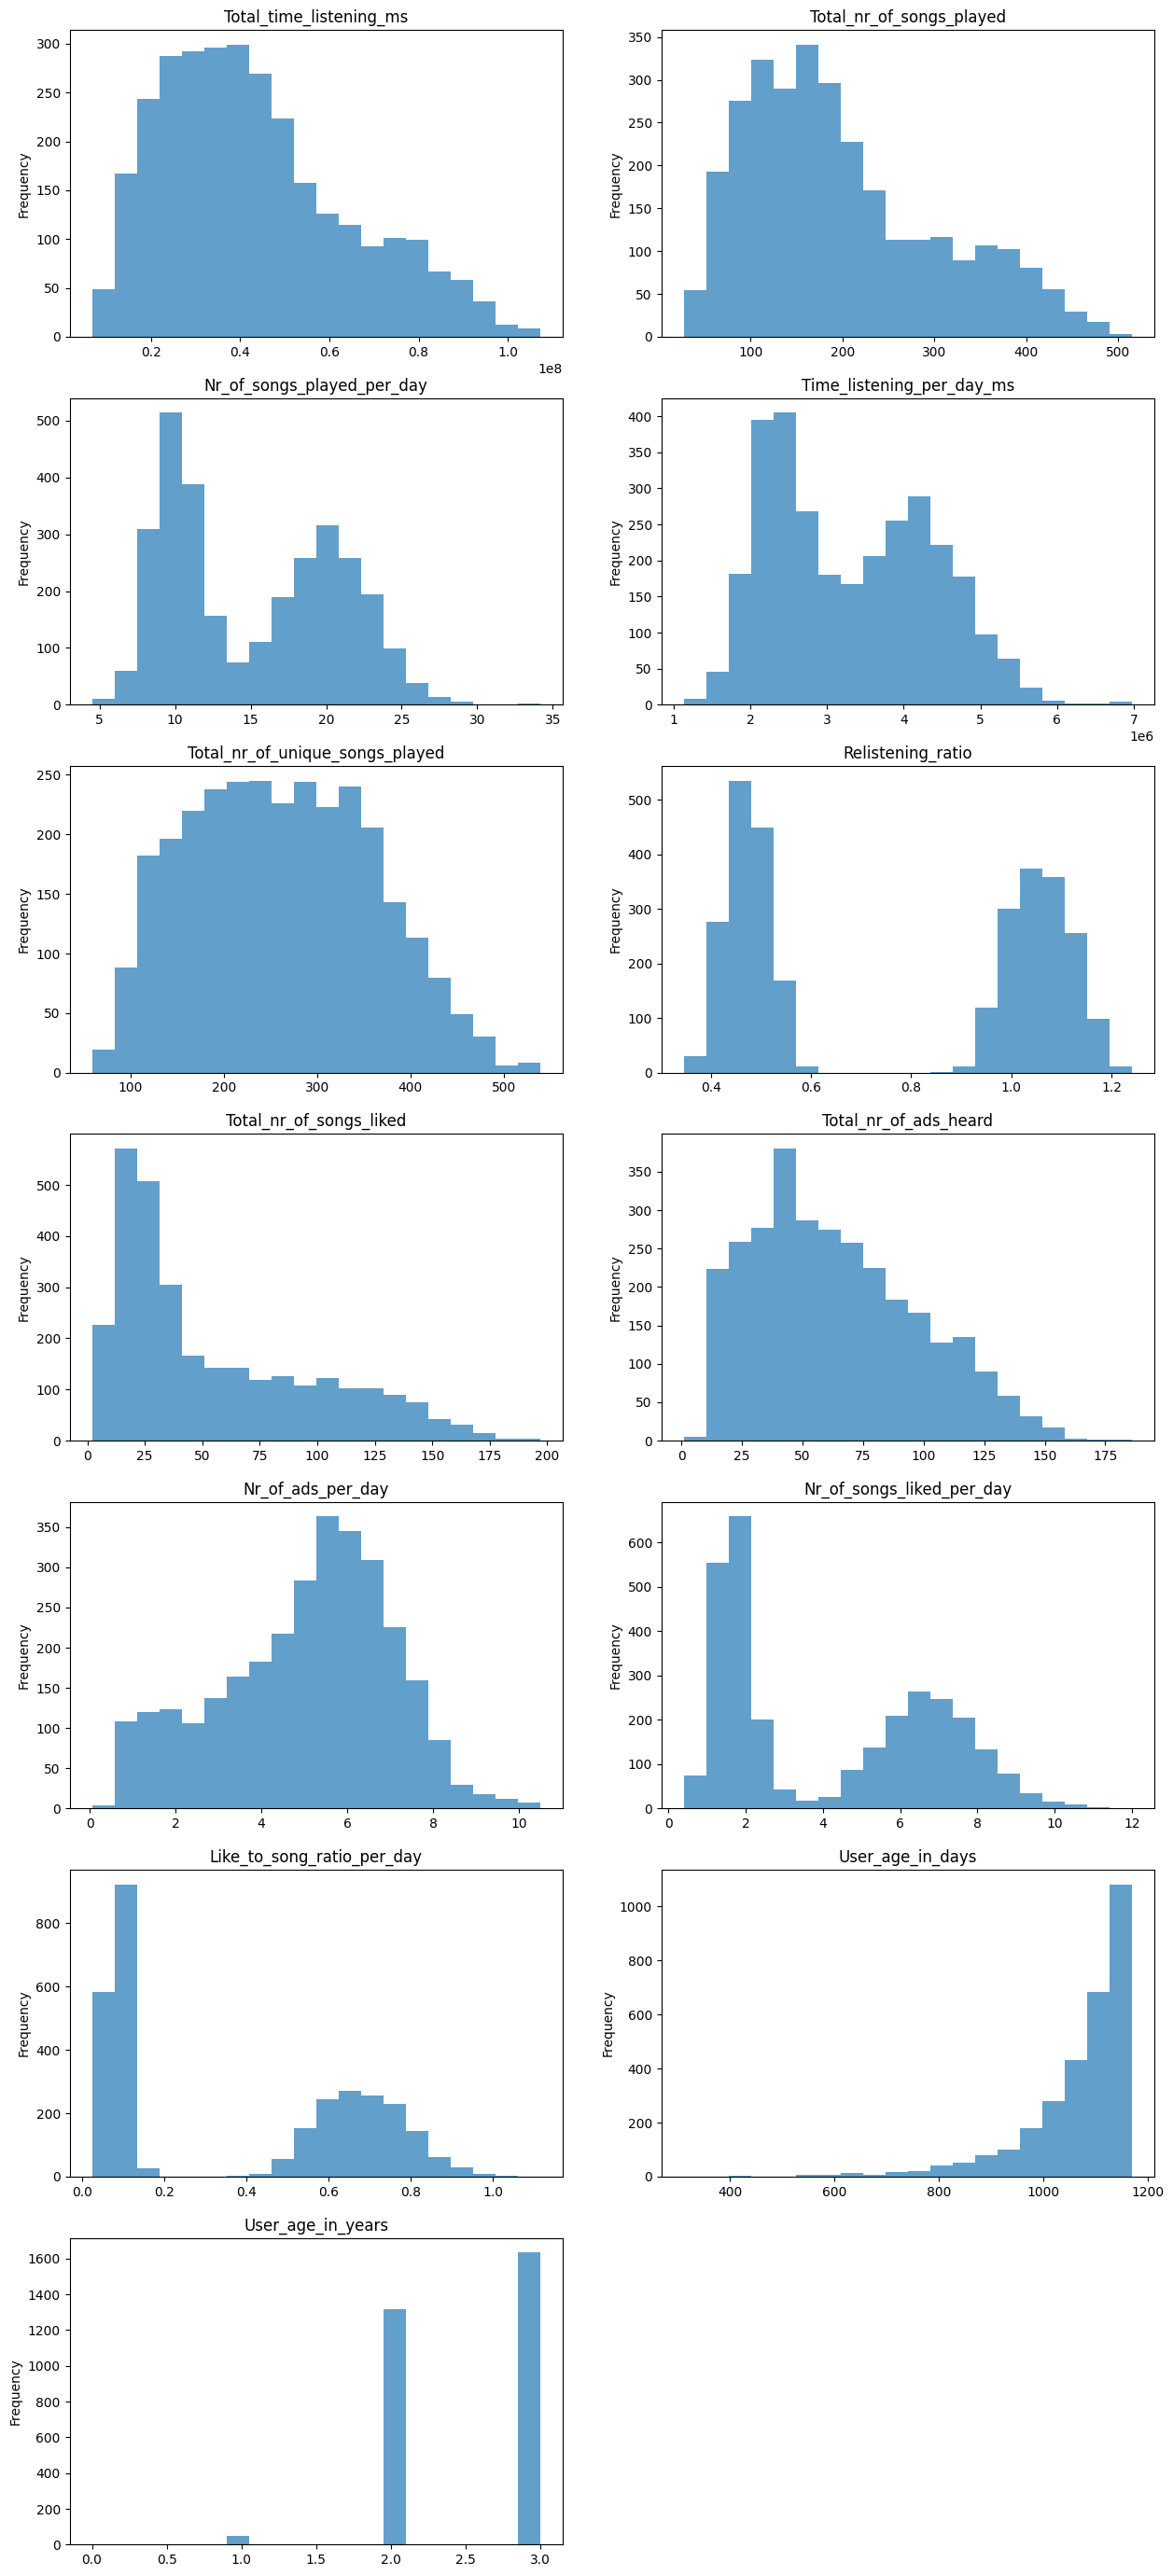

In [25]:

n_attributes = len(X.keys())

n_cols = 2  
n_rows = (n_attributes // n_cols) + (n_attributes % n_cols > 0)  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

axes = axes.flatten()

for idx, (x, ax) in enumerate(zip(X.keys(), axes)):
    X[x].plot(kind="hist", bins=20, alpha=0.7, ax=ax)
    ax.set_title(f"{x}")
    # ax.set_xlabel(x) 
    ax.set_ylabel('Frequency')  

for idx in range(n_attributes, len(axes)):
    axes[idx].axis('off')

plt.show()


In [26]:
# Standaryzacja wartości w X
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# print(X_standardized)


In [27]:
from sklearn.linear_model import LinearRegression


model = LinearRegression()

# Fit the model to the data
model.fit(X_standardized, Y)
Yp = model.predict(X_standardized)

# Get the regression coefficients (parameters)
print("Bias:", model.intercept_)
print("Coefficient:", model.coef_)
# If you have feature names, use them; if not, use numbers as feature labels
feature_names = [f'{str(i)}' for i in X_standardized.keys()]  # Change if you have actual names
weights = model.coef_[0]

Bias: [-0.168]
Coefficient: [[ 0.32300956 -0.05429933  0.38308582 -0.01462905  0.14812485 -0.7337004
  -0.28658878 -0.05218575 -0.53863206  0.49300066 -0.16074323  0.01477976
   0.0136729 ]]


In [28]:
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
print("MSE:", mean_squared_error(Y,np.sign(Yp)))
print("R2:", r2_score(Y,np.sign(Yp)))
print("Confusion Matrix:", confusion_matrix(Y,np.sign(Yp)))
# print([1 for v in Y.values if v == 1 ])
print(f"Y 1s {sum([1 for v in Y.values if v == 1 ])}  0s {sum([1 for v in Y.values if v == -1 ])}")
print(f"Yp 1s {sum([1 for v in np.sign(Yp) if v == 1 ])}  0s {sum([1 for v in np.sign(Yp) if v == -1 ])}")



MSE: 0.436
R2: 0.5513369336143308
Confusion Matrix: [[1743    9]
 [ 318  930]]
Y 1s 1248  0s 1752
Yp 1s 939  0s 2061


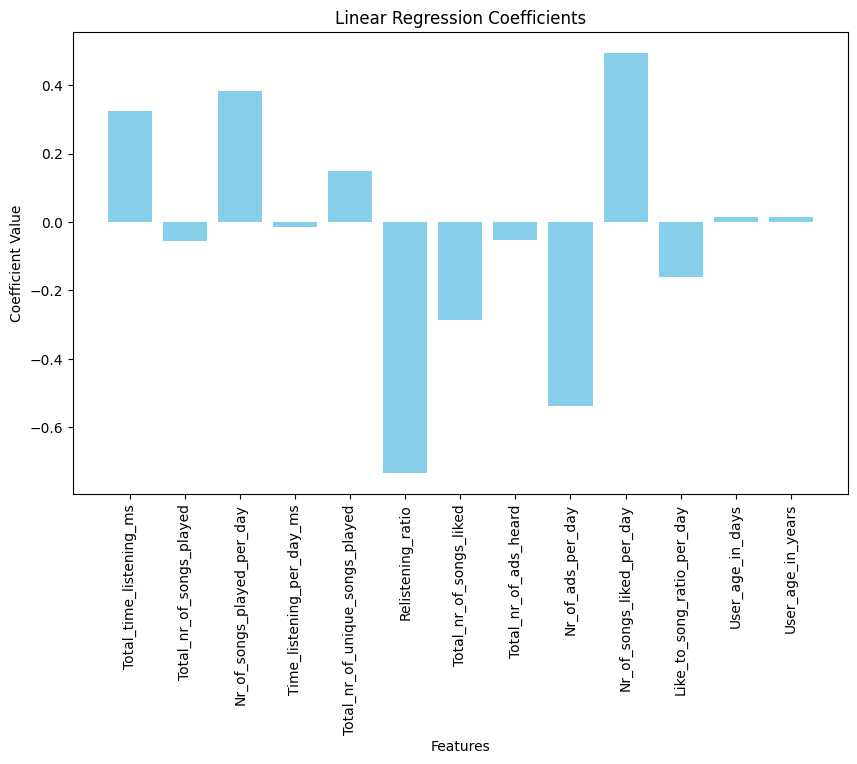

In [29]:

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(feature_names, model.coef_[0], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=90)
plt.show()
